In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime


In [2]:
lr = 1e-4
batch_size = 512*20
n_epochs = 100

hidden_size = 1024

train_ratio = 0.8

embedding_dim = 10


In [3]:
df = pd.read_csv(
    "../../data/MovieRatings/rating.csv",
    sep=",",
    header=0,
)

df.head()


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [4]:
user_ids = df.userId.astype("category").cat.codes.values
movie_ids = df.movieId.astype("category").cat.codes.values
targets = df["rating"].values - 2.5


In [5]:
amount_users = len(set(user_ids))
amount_movies = len(set(movie_ids))

print(f'Total amount of users: {amount_users}')
print(f'Total amount of movies: {amount_movies}')

Total amount of users: 138493
Total amount of movies: 26744


In [6]:
n_samples = df.shape[0]

shuffle = np.random.permutation(n_samples)
user_ids, movie_ids, targets = user_ids[shuffle], movie_ids[shuffle], targets[shuffle]


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device {device} is being used")


Device cuda is being used


In [8]:
n_to_train = int(n_samples * train_ratio)

train_users = user_ids[:n_to_train]
test_users = user_ids[n_to_train:]
train_movies = movie_ids[:n_to_train]
test_movies = movie_ids[n_to_train:]

train_targets = targets[:n_to_train]
test_targets = targets[n_to_train:]

train_data = (train_users, train_movies, train_targets)
test_data = (test_users, test_movies, train_targets)

In [9]:
class Recommender(nn.Module):
    def __init__(
        self,
        users_num,
        movies_num,
        embedding_dim,
        hidden_size
    ):
        super(Recommender, self).__init__()
        self.embed_user = nn.Embedding(
            num_embeddings=users_num,
            embedding_dim=embedding_dim,
        )
        self.embed_movie = nn.Embedding(
            num_embeddings=movies_num,
            embedding_dim=embedding_dim,
        )
        
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, users, movies):
        users_emb = self.embed_user(users)
        movies_emb = self.embed_movie(movies)

        merged_inp = torch.concat((users_emb, movies_emb), dim=1)
        
        outputs = self.fc1(merged_inp)
        outputs = F.relu(outputs)
        
        outputs = self.fc2(outputs)

        return outputs


In [10]:
def train_batch(model, criterion, optimizer, train_data, test_data, batch_size=1024, n_epochs=100):
    train_users, train_movies, train_targets = train_data
    test_users, test_movies, test_targets = test_data

    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

    batches_per_epoch_train = int(np.floor(len(train_users) / batch_size))
    batches_per_epoch_test = int(np.floor(len(test_users) / batch_size))

    start_time = datetime.now()

    for it in range(n_epochs):

        shuffle = np.random.permutation(len(train_users))
        train_users, train_movies, train_targets = (
            train_users[shuffle],
            train_movies[shuffle],
            train_targets[shuffle],
        )

        train_loss = []

        for j in range(batches_per_epoch_train):

            users = train_users[j * batch_size : (j + 1) * batch_size]
            movies = train_movies[j * batch_size : (j + 1) * batch_size]
            targets = train_targets[j * batch_size : (j + 1) * batch_size]

            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets.astype(np.float32))

            targets = targets.view(-1, 1)

            users = users.to(device)
            movies = movies.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        test_loss = []

        for j in range(batches_per_epoch_test):

            users = test_users[j * batch_size : (j + 1) * batch_size]
            movies = test_movies[j * batch_size : (j + 1) * batch_size]
            targets = test_targets[j * batch_size : (j + 1) * batch_size]

            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets.astype(np.float32))

            targets = targets.view(-1, 1)

            users = users.to(device)
            movies = movies.to(device)
            targets = targets.to(device)

            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        train_losses[it] = np.mean(train_loss)
        test_losses[it] = np.mean(test_loss)

    end_time = datetime.now()

        # print(
        #     f"Iteration: {it+1:4.0f}/{n_epochs}\tTrain Loss: {train_losses[it]:.6f}\tTest Loss: {test_losses[it]:.6f}\tDuration: {end_time-start_time}"
        # )
        
    print(
        f"Train Loss: {train_losses[n_epochs-1]:.6f}\tTest Loss: {test_losses[n_epochs-1]:.6f}\tDuration: {end_time-start_time}"
    )

    return train_losses, test_losses


Train Loss: 1.113972	Test Loss: 1.124958	Duration: 0:22:29.509740
Train Loss: 1.066537	Test Loss: 1.142556	Duration: 0:22:12.065700


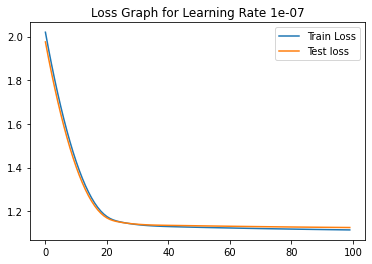

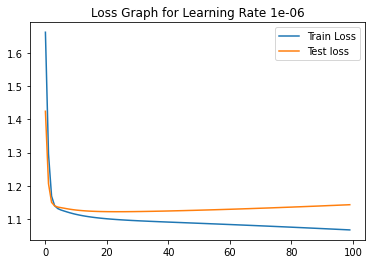

In [11]:
for i in range(-7, -5):
    model = Recommender(
        users_num=amount_users,
        movies_num=amount_movies,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
    )

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=10**i)
    criterion = nn.MSELoss()

    train_losses, test_losses = train_batch(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_data=train_data,
        test_data=test_data,
        batch_size=batch_size,
        n_epochs=n_epochs,
    )

    plt.figure(i + 10)
    plt.title(f"Loss Graph for Learning Rate {10**i}")
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test loss")
    plt.legend()


To improve the results you may want to set different initial weights to fc layers